# Knife MI analysis

In [5]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm as tqdm
import numpy as np
import json
import sklearn
from sklearn.decomposition import PCA

from utils import MolecularFeatureExtractor
from models.model_paths import get_model_path

In [6]:
DATASET = "ZINC"
LENGTH = 2
MDS_DIM = 0

DESCRIPTORS = [
            "ecfp",
            "estate",
            "fcfp",
            "erg",
            "rdkit",
            "topological",
            "avalon",
            "maccs",
            "secfp",
            "scaffoldkeys",
            "cats",
            "gobbi",
            "pmapper",
            "cats/3D",
            "gobbi/3D",
            "pmapper/3D",
            "ScatteringWavelet",
        ]
MODELS = [
    "ContextPred",
    "GPT-GNN",
    "GraphMVP",
    "GROVER",
    "EdgePred",
    "AttributeMask",
    "GraphLog",
    "GraphCL",
    "InfoGraph",
    "Not-trained",
    "MolBert",
    "ChemBertMLM-5M",
    "ChemBertMLM-10M",
    "ChemBertMLM-77M",
    "ChemBertMTR-5M",
    "ChemBertMTR-10M",
    "ChemBertMTR-77M",
    "DenoisingPretrainingPQCMv4"
]
MODELS_PATH = get_model_path(models=MODELS)


with open(f"data/{DATASET}/smiles.json", "r") as f:
    smiles = json.load(f)

if not len(smiles) > 50000:
    import datamol as dm
    mols = dm.read_sdf(f"data/{DATASET}/preprocessed.sdf")

    feature_extractor = MolecularFeatureExtractor(dataset=DATASET, length=LENGTH, mds_dim=MDS_DIM, device="cuda")
    # same plots but in 3D

    fig,axes = plt.subplots(3,len(MODELS)//3,figsize=(len(MODELS)//3*5,3*5), subplot_kw={'projection': '3d'})
    axes = axes.flatten()

    for i,model in enumerate(MODELS):
        embeddings = feature_extractor.get_features(smiles, mols = mols, name=model,feature_type="model",path = MODELS_PATH.get(model, None))
        # nromalize embeddings
        embeddings = (embeddings - embeddings.mean(axis=0))/(embeddings.std(axis=0) +1e-8)
        pca = PCA(n_components=3)
        embeddings_pca = pca.fit_transform(embeddings.cpu())
        df = pd.DataFrame(embeddings_pca, columns=[f"PC{i}" for i in range(1,4)])
        df["smiles"] = smiles
        # using pyplot
        axes[i].scatter3D(df["PC1"], df["PC2"], df["PC3"], c=df["PC1"], cmap='viridis', alpha=0.1)
        axes[i].set_title(model)


In [7]:
full_df_loss_cond = []
full_df_loss_marg = []
RESULTS_PATH = f"results/{DATASET}/{LENGTH}/{MDS_DIM}"
dir_path = os.path.join(RESULTS_PATH, "losses")

for file in tqdm(os.listdir(dir_path)):
    #one plot for each model showing the loss on all descriptors. Files are {model}_{descriptor}_{run}_XY.csv
    if file.endswith(".csv"):
        file_split = file[:-4].split("_")
        if file_split[0] == DATASET and file_split[1] in MODELS and file_split[-2] == str(LENGTH):
            if file_split[-1] == "marg":
                model, descriptor = file.split("_")[:2]
                df_tmp = pd.read_csv(os.path.join(dir_path, file))
                full_df_loss_marg.append(df_tmp)
            else:
                model, descriptor = file.split("_")[:2]
                df_tmp = pd.read_csv(os.path.join(dir_path, file))
                full_df_loss_cond.append(df_tmp)

full_df_loss_cond = pd.concat(full_df_loss_cond)
full_df_loss_marg = pd.concat(full_df_loss_marg)



100%|██████████| 54/54 [00:00<00:00, 645.53it/s]


100%|██████████| 18/18 [00:00<00:00, 47.57it/s]


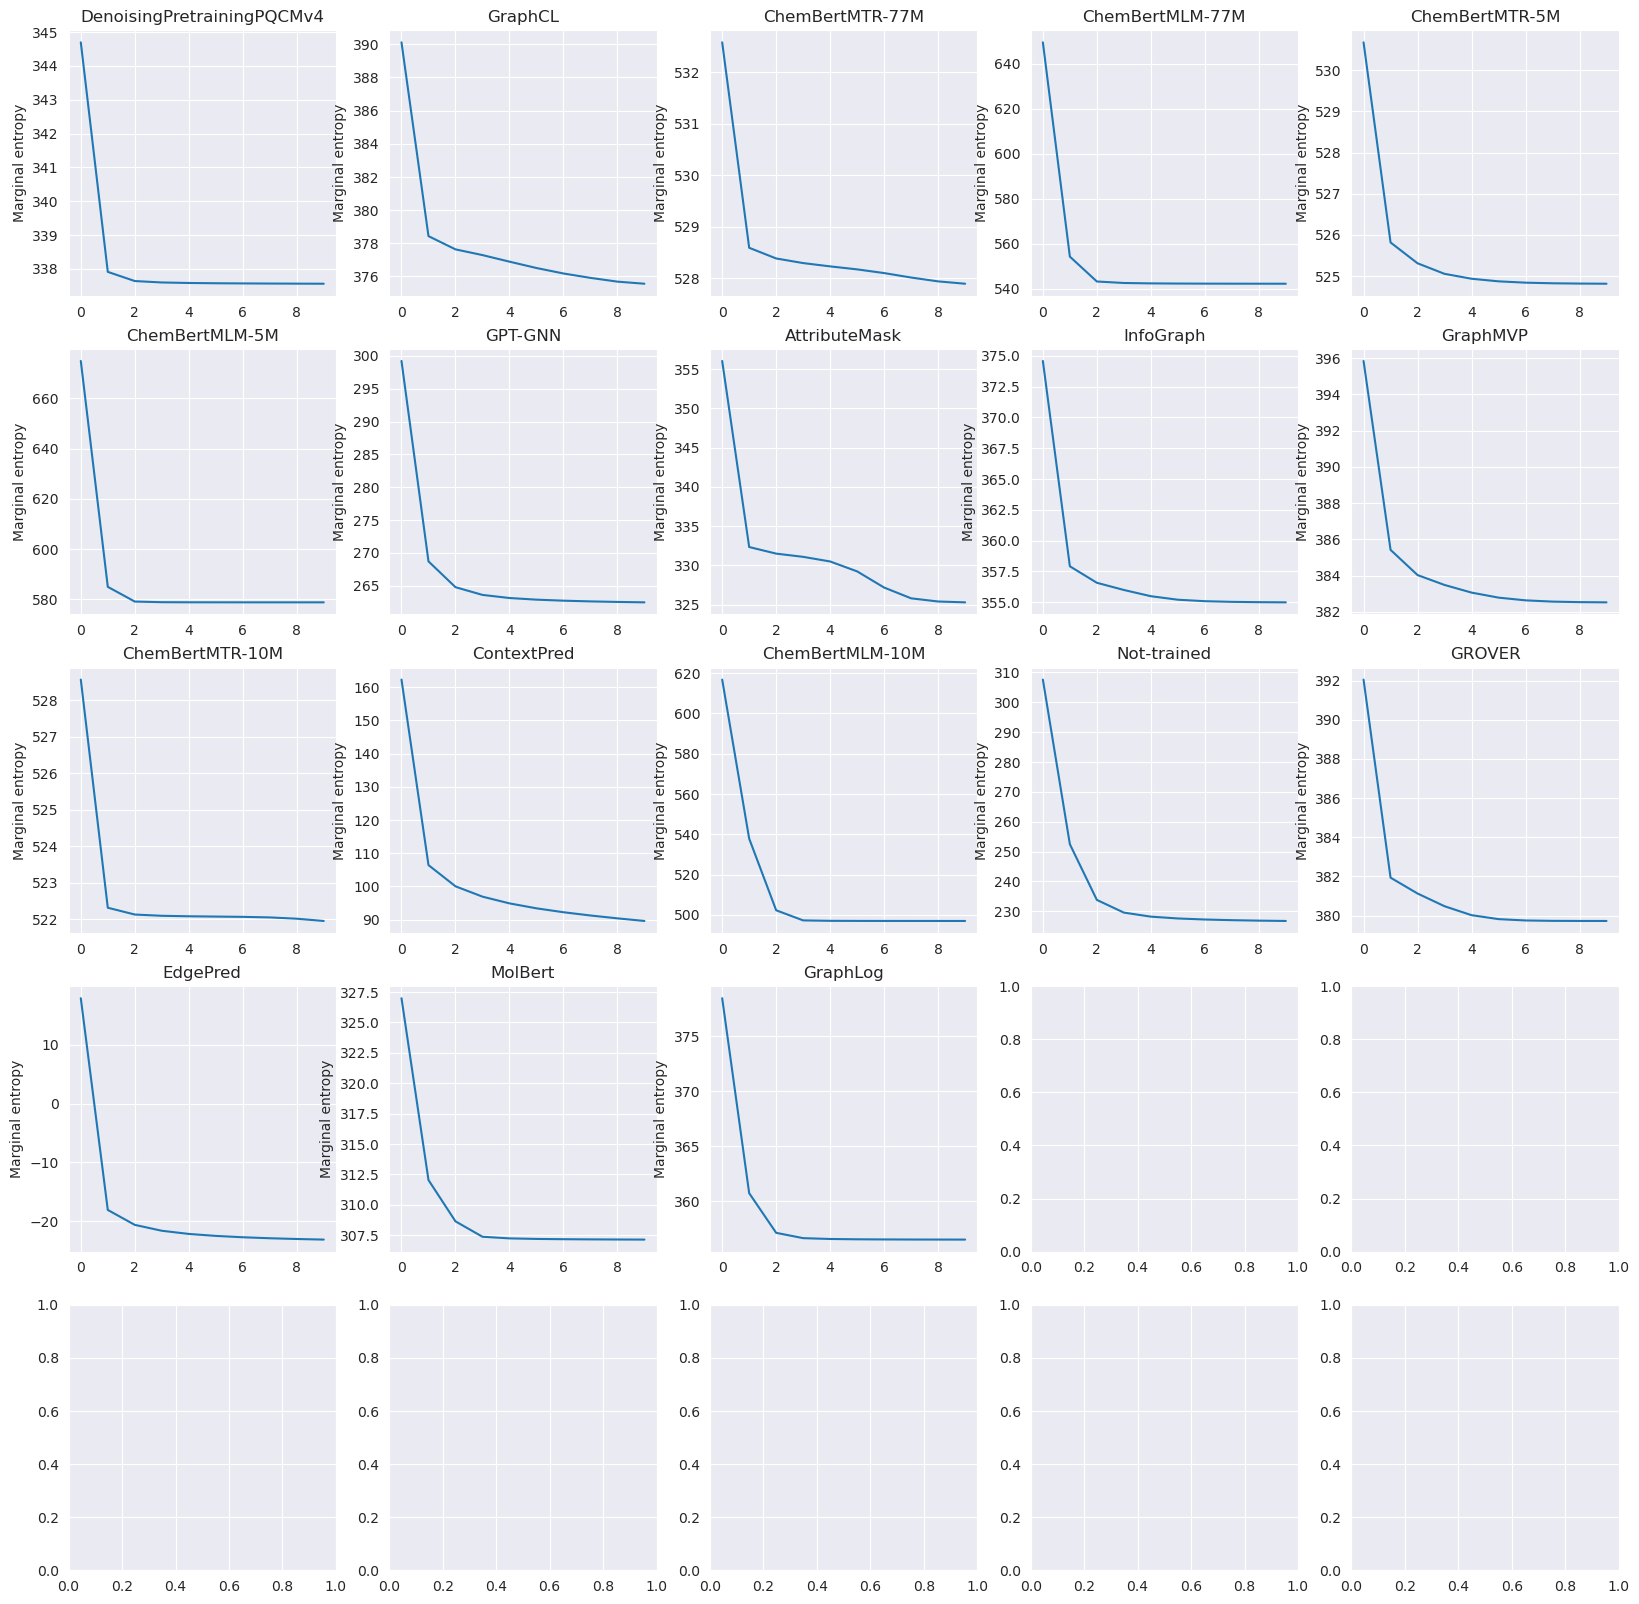

In [8]:
n_rows = np.ceil(full_df_loss_cond.Y.nunique()/5).astype(int)+1
n_cols = 5
fig, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,4*n_rows))
axes = axes.flatten()
for i, model in enumerate(tqdm(full_df_loss_marg.X.unique())):
    df_tmp = full_df_loss_marg[full_df_loss_marg.X == model]
    sns.lineplot(data=df_tmp, x="epoch", y="marg_ent", hue="X", ax=axes[i], estimator=None, errorbar= None, n_boot=0, legend=False)
    axes[i].set_title(model)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Marginal entropy")

In [9]:
# remove EdgePred
full_df_loss_cond = full_df_loss_cond[full_df_loss_cond.Y != "EdgePred"]
full_df_loss_cond = full_df_loss_cond[full_df_loss_cond.X != "EdgePred"]

full_df_loss_margin = full_df_loss_marg[full_df_loss_marg.X != "EdgePred"]

100%|██████████| 17/17 [00:02<00:00,  7.46it/s]


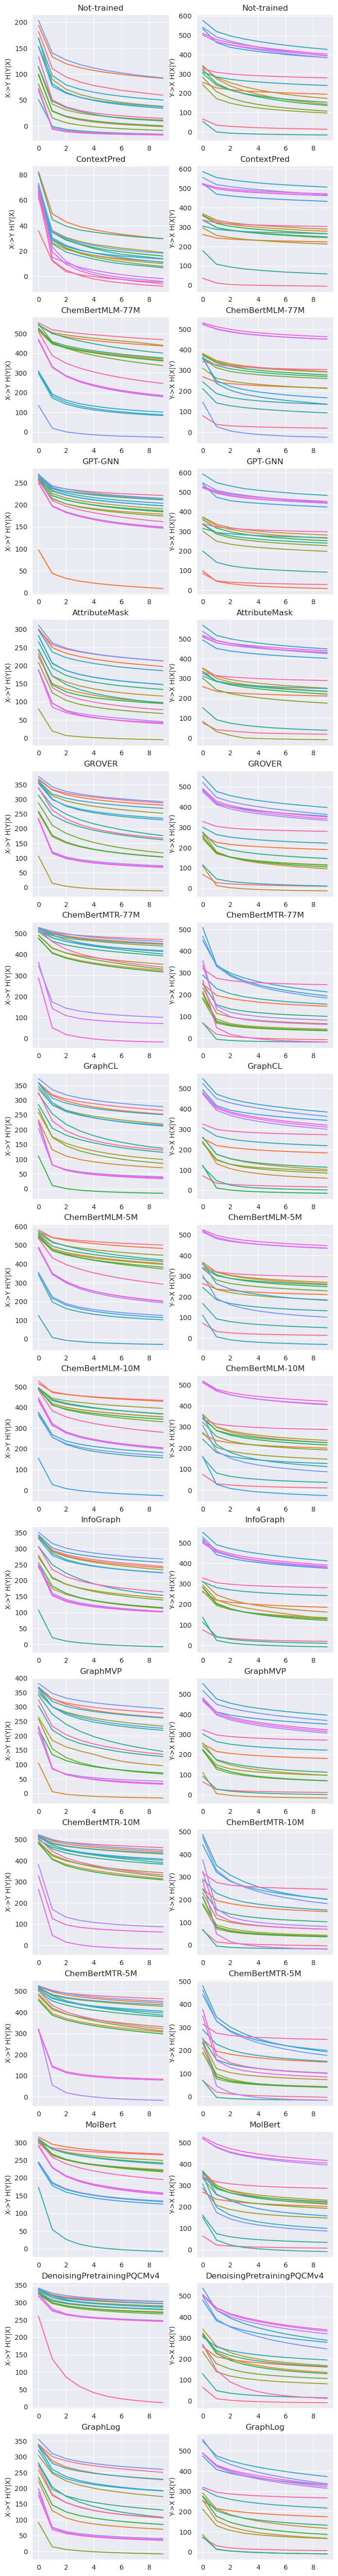

In [10]:
n_rows = full_df_loss_cond.Y.nunique()
n_cols = 2
fig, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,4*n_rows))


for i, model in enumerate(tqdm(full_df_loss_cond.Y.unique())):
    df_tmp = full_df_loss_cond[(full_df_loss_cond.Y == model) & (full_df_loss_cond.direction == "X->Y")]
    sns.lineplot(data=df_tmp, x="epoch", y="cond_ent", hue="X", ax=axes[i,0], estimator=None, errorbar= None, n_boot=0, legend=False)
    axes[i,0].set_title(model)
    axes[i,0].set_xlabel("")
    axes[i,0].set_ylabel("X->Y H(Y|X)")

    df_tmp = full_df_loss_cond[(full_df_loss_cond.Y == model) & (full_df_loss_cond.direction == "Y->X")]

    sns.lineplot(data=df_tmp, x="epoch", y="cond_ent", hue="X", ax=axes[i,1], estimator=None, errorbar= None, n_boot=0, legend=False)
    axes[i,1].set_title(model)
    axes[i,1].set_xlabel("")
    axes[i,1].set_ylabel("Y->X H(X|Y)")


## MI between descriptors and embeddings

In [ ]:
import os
import numpy as np

all_df = []
for file in os.listdir(RESULTS_PATH):
    if file.endswith(".csv"):
        file_split = file[:-4].split("_")
        if file_split[0] == DATASET and file_split[-1] == str(LENGTH):
            all_df.append(pd.read_csv(os.path.join(RESULTS_PATH, file)))
df = pd.concat(all_df)

#df =df[df.Y.isin(DESCRIPTORS)]
df


## Clustermap

In [ ]:
df["I(Y->X)/dim"] = df["I(Y->X)"]/df["X_dim"]
df["I(X->Y)/dim"] = df["I(X->Y)"]/df["Y_dim"]

df["I(Y->X)/I(X)"] = df["I(Y->X)"]/df["I(X)"]
df["I(X->Y)/I(Y)"] = df["I(X->Y)"]/df["I(Y)"]

df["I(Y->X)/I(X)"] = df["I(Y->X)"]/df["I(X)"]
df["I(X->Y)/I(Y)"] = df["I(X->Y)"]/df["I(Y)"]



df["I(Y->X) - I(X->Y)"] =  df["I(Y->X)"]-df["I(X->Y)"]
df["I(Y->X)/dim - I(X->Y)/dim"] = df["I(Y->X)/dim"]-df["I(X->Y)/dim"]
df["I(Y->X)/I(X) - I(X->Y)/I(Y)"] = df["I(Y->X)/I(X)"]-df["I(X->Y)/I(Y)"]

df["I(Y->X) / I(X->Y)"] =  df["I(Y->X)"]/(df["I(X->Y)"] + 1e-8)
df["I(Y->X)/dim / I(X->Y)/dim"] = df["I(Y->X)/dim"]/(df["I(X->Y)/dim"] + 1e-8)
df["I(Y->X)/I(X) / I(X->Y)/I(Y)"] = df["I(Y->X)/I(X)"]/(df["I(X->Y)/I(Y)"] + 1e-8)

df = df.dropna()

In [ ]:
df.X = df.X.apply(lambda x: x[:-1])

In [ ]:
df = df[(df.Y!= "EdgePred") & ("EdgePred" != df.X)]

In [ ]:
df[df.X == "DenoisingPretrainingPQCMv4"]

In [ ]:
keys = [
    "I(Y->X)", "I(X->Y)", "I(Y->X)/dim", "I(X->Y)/dim",
    "I(Y->X) - I(X->Y)", "I(Y->X)/dim - I(X->Y)/dim",
]

In [ ]:
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(15, 5), sharex=True)

sns.scatterplot(data=df, y="I(Y->X)", x="X_dim", hue="X", ax=axes[0], legend=False)

sns.scatterplot(data=df, y="I(Y->X)/dim", x="X_dim", hue="X", ax=axes[1], legend=False)

sns.scatterplot(data=df, y="I(Y->X)/I(X)", x="X_dim", hue="X", ax=axes[2], legend=False)


In [ ]:
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(15, 5), sharex=True)

sns.scatterplot(data=df, y="I(X->Y)", x="Y_dim", hue="Y", ax=axes[0], legend=False)
sns.scatterplot(data=df, y="I(X->Y)/dim", x="Y_dim", hue="Y", ax=axes[1], legend=False)
sns.scatterplot(data=df, y="I(X->Y)/I(Y)", x="Y_dim", hue="Y", ax=axes[2], legend=False)


In [ ]:
df

In [ ]:
def plot_cmap(df, keys, cmap = "copper", vmin = None, vmax = None, center = None):
    if vmax is None:
        vmax = [None]*len(keys)
    if vmin is None:
        vmin = [None]*len(keys)
    for i, key in enumerate(keys):
        df_pivot = df.pivot_table(index="X", columns="Y", values=key, aggfunc="mean")
        from scipy.cluster.hierarchy import linkage
        link = linkage(df_pivot, method="ward")
        cluster = sns.clustermap(
            df_pivot, row_linkage=link, col_linkage=link,
            cmap=cmap, figsize=(8,8), vmin=vmin[i], vmax=vmax[i], center=center
        )
        cluster.savefig("fig/cluster_{}.png".format(i))
        plt.clf()

    import matplotlib.image as mpimg
    fig, axes = plt.subplots(1,len(keys), figsize=(8*len(keys),8))
    for i, key in enumerate(keys):
        axes[i].imshow(mpimg.imread("fig/cluster_{}.png".format(i)))
        axes[i].axis("off")
        axes[i].set_title(key)
    plt.show()

In [ ]:
%matplotlib inline
plot_cmap(
    df,
    ["I(X->Y)", "I(X->Y)/dim", "I(X->Y)/I(Y)"],
    cmap="viridis",
)

In [ ]:
plot_cmap(
    df,
    ["I(Y->X) - I(X->Y)", "I(Y->X)/dim - I(X->Y)/dim", "I(Y->X)/I(X) - I(X->Y)/I(Y)"],
    cmap="seismic",
    center=0
)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

sns.set_style("whitegrid")

cmap =sns.color_palette("crest", as_cmap=True)


table = df.pivot_table(index="X", columns="Y", values="I(X->Y)/dim", aggfunc="mean")
# remove lines and columns containing xsum in index and columns

# compute 1/x for each value

G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))




avg_weight = {n : np.median([d[2]['weight'] for d in G.out_edges(n, data=True)]) for n in G.nodes()}
avg_income = {n : np.median([d[2]['weight'] for d in G.in_edges(n, data=True)]) for n in G.nodes()}


layout = nx.spring_layout(G, k=0.7, iterations=10000)
fig, ax = plt.subplots(figsize=(20, 10))

def make_border_color(strength, cmap, vmin, vmax):
    return cmap((strength - vmin) / (vmax - vmin))


# draw nodes with border color based on avg_income
nx.draw_networkx_nodes(G, layout, node_size=1000, node_color=list(avg_weight.values()), cmap=cmap, vmin=min(avg_weight.values()), vmax=max(avg_weight.values()), ax=ax, linewidths=4, edgecolors=[make_border_color(avg_income[n], cmap, min(avg_income.values()), max(avg_income.values())) for n in G.nodes()])

edge_weights = np.array([d[2]['weight'] for d in G.edges(data=True)])
edge_weights = (edge_weights - edge_weights.min())/(edge_weights.max() - edge_weights.min())
edge_weights_alpha = edge_weights**4

nx.draw_networkx_edges(G, layout, width=3*(edge_weights)**2, edge_color=edge_weights, edge_cmap=cmap, ax=ax, arrowsize=30, arrowstyle='-|>', connectionstyle='arc3, rad = 0.4',  alpha=edge_weights_alpha)

nx.draw_networkx_labels(G, layout, font_size=14, font_color='black', font_weight='bold', ax=ax)




# add cmap legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(avg_weight.values()), vmax=max(avg_weight.values())))
sm._A = []
plt.colorbar(sm, ax=plt.gca())

# add white contour to all texts in the figure
for text in plt.gca().texts:
    text.set_path_effects([patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal()])

plt.tight_layout()
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

sns.set_style("whitegrid")

cmap =sns.color_palette("crest", as_cmap=True)


table = df.pivot_table(index="X", columns="Y", values="I(X->Y)/dim", aggfunc="mean")
# remove lines and columns containing xsum in index and columns

# compute 1/x for each value

G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))




avg_weight = {n : np.median([d[2]['weight'] for d in G.out_edges(n, data=True)]) for n in G.nodes()}
avg_income = {n : np.median([d[2]['weight'] for d in G.in_edges(n, data=True)]) for n in G.nodes()}


layout = nx.spring_layout(G, k=0.7, iterations=10000)
fig, ax = plt.subplots(figsize=(20, 10))

def make_border_color(strength, cmap, vmin, vmax):
    return cmap((strength - vmin) / (vmax - vmin))


# draw nodes with border color based on avg_income
nx.draw_networkx_nodes(G, layout, node_size=1000, node_color=list(avg_weight.values()), cmap=cmap, vmin=min(avg_weight.values()), vmax=max(avg_weight.values()), ax=ax, linewidths=4, edgecolors=[make_border_color(avg_income[n], cmap, min(avg_income.values()), max(avg_income.values())) for n in G.nodes()])

edge_weights = np.array([d[2]['weight'] for d in G.edges(data=True)])
edge_weights = (edge_weights - edge_weights.min())/(edge_weights.max() - edge_weights.min())
edge_weights_alpha = edge_weights**1

nx.draw_networkx_edges(G, layout, width=3*(edge_weights)**2, edge_color=edge_weights, edge_cmap=cmap, ax=ax, arrowsize=30, arrowstyle='-|>', connectionstyle='arc3, rad = 0.4',  alpha=edge_weights_alpha)

nx.draw_networkx_labels(G, layout, font_size=14, font_color='black', font_weight='bold', ax=ax)




# add cmap legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(avg_weight.values()), vmax=max(avg_weight.values())))
sm._A = []
plt.colorbar(sm, ax=plt.gca())

# add white contour to all texts in the figure
for text in plt.gca().texts:
    text.set_path_effects([patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal()])

plt.tight_layout()
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

sns.set_style("whitegrid")

cmap =sns.color_palette("crest", as_cmap=True)


table = df.pivot_table(index="X", columns="Y", values="I(X->Y)", aggfunc="mean")
# remove lines and columns containing xsum in index and columns

# compute 1/x for each value

G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))




avg_weight = {n : np.median([d[2]['weight'] for d in G.out_edges(n, data=True)]) for n in G.nodes()}
avg_income = {n : np.median([d[2]['weight'] for d in G.in_edges(n, data=True)]) for n in G.nodes()}


layout = nx.spring_layout(G, k=0.7, iterations=10000)
fig, ax = plt.subplots(figsize=(20, 10))

def make_border_color(strength, cmap, vmin, vmax):
    return cmap((strength - vmin) / (vmax - vmin))


# draw nodes with border color based on avg_income
nx.draw_networkx_nodes(G, layout, node_size=1000, node_color=list(avg_weight.values()), cmap=cmap, vmin=min(avg_weight.values()), vmax=max(avg_weight.values()), ax=ax, linewidths=4, edgecolors=[make_border_color(avg_income[n], cmap, min(avg_income.values()), max(avg_income.values())) for n in G.nodes()])

edge_weights = np.array([d[2]['weight'] for d in G.edges(data=True)])
edge_weights = (edge_weights - edge_weights.min())/(edge_weights.max() - edge_weights.min())
edge_weights_alpha = edge_weights**2

nx.draw_networkx_edges(G, layout, width=3*(edge_weights)**2, edge_color=edge_weights, edge_cmap=cmap, ax=ax, arrowsize=30, arrowstyle='-|>', connectionstyle='arc3, rad = 0.4',  alpha=edge_weights_alpha)

nx.draw_networkx_labels(G, layout, font_size=14, font_color='black', font_weight='bold', ax=ax)




# add cmap legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(avg_weight.values()), vmax=max(avg_weight.values())))
sm._A = []
plt.colorbar(sm, ax=plt.gca())

# add white contour to all texts in the figure
for text in plt.gca().texts:
    text.set_path_effects([patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal()])

plt.tight_layout()
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()

In [ ]:
df.X.unique()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

sns.set_style("whitegrid")

cmap =sns.color_palette("vlag", as_cmap=True)

smiles_models= [
    "ChemBertMLM-5M",
    "ChemBertMLM-10M",
    "ChemBertMLM-77M",
    "ChemBertMTR-5M",
    "ChemBertMTR-10M",
    "ChemBertMTR-77M",
    "MolBert"
]

table = df[~df.X.isin(smiles_models) & ~df.Y.isin(smiles_models)].pivot_table(index="X", columns="Y", values="I(X->Y)/dim", aggfunc="mean")

G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))




avg_weight = {n : np.median([d[2]['weight'] for d in G.out_edges(n, data=True)]) for n in G.nodes()}
avg_income = {n : np.median([d[2]['weight'] for d in G.in_edges(n, data=True)]) for n in G.nodes()}
# remove edge with weighht <= 50
# for edge in list(G.edges(data=True)):
#     if edge[2]['weight'] >= 1/55:
#         G.remove_edge(edge[0], edge[1])


layout = nx.spring_layout(G, k=-0.9, iterations=100)
fig, ax = plt.subplots(figsize=(20, 10))

def make_border_color(strength, cmap, vmin, vmax):
    return cmap((strength - vmin) / (vmax - vmin))


# draw nodes with border color based on avg_income
nx.draw_networkx_nodes(G, layout, node_size=1000, node_color=list(avg_weight.values()), cmap=cmap, vmin=min(avg_weight.values()), vmax=max(avg_weight.values()), ax=ax, linewidths=4, edgecolors=[make_border_color(avg_income[n], cmap, min(avg_income.values()), max(avg_income.values())) for n in G.nodes()])

edge_weights = np.array([d[2]['weight'] for d in G.edges(data=True)])
edge_weights = (edge_weights - edge_weights.min())/(edge_weights.max() - edge_weights.min())

edge_weights_alpha = abs(2*(edge_weights-0.5))**(0.8)

nx.draw_networkx_edges(G, layout, width=3*(edge_weights)**2, edge_color=edge_weights, edge_cmap=cmap, ax=ax, arrowsize=30, arrowstyle='-|>', connectionstyle='arc3, rad = 0.4',  alpha=edge_weights_alpha)

nx.draw_networkx_labels(G, layout, font_size=14, font_color='black', font_weight='bold', ax=ax)




# add cmap legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(avg_weight.values()), vmax=max(avg_weight.values())))
sm._A = []
plt.colorbar(sm, ax=plt.gca())

# add white contour to all texts in the figure
for text in plt.gca().texts:
    text.set_path_effects([patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal()])

plt.tight_layout()
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()

In [ ]:
edge_weights.min()